# Constant Interval

We will choose a fixed parameter a > 0 for this strategy. In the beginning, we will provide liquidity in a symmetric interval around the current price. This interval will never be adjusted. More specifically, we will choose the interval [p − a, p + a], where p is the price at the beginning.
For the USDC-ETH pool, we will choose a ∈ [10, 40000], which means that the size is between 10 and 40000 basis points, or 0.1% and 400%. It does not make sense to choose another a because, at any time, the price is always in [p−a,p+a].

Import code dependencies

In [1]:
from _decimal import Decimal
from typing import List, Dict

import pandas as pd
from matplotlib.pylab import plt
import matplotlib.dates as mdates

from demeter import MarketInfo
from demeter.broker import AccountStatus

Set matplotlib to show formatted account status

In [2]:
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

Make plot about price and account value / position net value

In [3]:
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name + "_net_value"]
    value_in_account = account_status["USDC"] + account_status["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()

Add dependence about run Actuator

In [4]:
from datetime import date
import pandas as pd
from demeter import Actuator, MarketInfo, TokenInfo, Strategy, ChainType, EvaluatorEnum
from demeter.uniswap import UniV3Pool, UniLpMarket

Set pandas output format

In [5]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Constant Interval strategy with code to add liquidity at constant interval around current price.

In [6]:
class ConstantIntervalStrategy(Strategy):
    def __init__(self, a=100):
        super().__init__()
        self.a = a

    def initialize(self):
        market: UniLpMarket = self.markets[market_key]
        init_price = market.market_status.data.price
        market.even_rebalance(init_price)  # rebalance all reserve token#
        # new_position(self, baseToken, quoteToken, usd_price_a, usd_price_b):
        # what is  base/quote "https://corporatefinanceinstitute.com/resources/knowledge/economics/currency-pair/"
        market.add_liquidity(init_price - self.a, init_price + self.a)
        super().__init__()

Main logic to run Actuator, init two token and market with key "market1"

In [7]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("market1")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = ConstantIntervalStrategy(200)

market.data_path = "../data"
market.load_data(ChainType.polygon.name, "0x45dda9cb7c25131df268515131f647d726f50608", date(2023, 8, 13), date(2023, 8, 17))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2023-11-03 10:06:45,935 - INFO - start load files from 2023-08-13 to 2023-08-17...
2023-11-03 10:06:46,005 - INFO - load file complete, preparing...
2023-11-03 10:06:46,362 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [8]:
actuator.run(evaluator=[
        EvaluatorEnum.max_draw_down,
        EvaluatorEnum.annualized_returns,
        EvaluatorEnum.net_value,
        EvaluatorEnum.profit,
        EvaluatorEnum.net_value_up_down_rate,
        EvaluatorEnum.eth_up_down_rate,
        EvaluatorEnum.position_fee_profit,
        EvaluatorEnum.position_fee_annualized_returns,
        EvaluatorEnum.position_market_time_rate,
    ])
# get result
evaluating_result: Dict[EvaluatorEnum, Decimal] = actuator.evaluating_indicator

actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)

2023-11-03 10:06:46,378 - INFO - init strategy...
2023-11-03 10:06:46,381 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:04<00:00, 1528.69it/s]
2023-11-03 10:06:51,121 - INFO - main loop finished
2023-11-03 10:06:51,181 - INFO - Start calculate evaluating indicator...
/Users/florije/PycharmProjects/demeter/demeter/core/evaluating_indicator.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fee_df.sort_values(by=["market1_base_uncollected", "market1_quote_uncollected"], ascending=[False, False], inplace=True)
2023-11-03 10:06:51,250 - INFO - Evaluating indicator has finished it's job.
2023-11-03 10:06:51,251 - INFO - Print actuator summary
2023-11-03 10:06:51,265 - INFO - Backtesting finished, 

Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.0541238649054306471590320181
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                       pending0                          pending1        liquidity
0      200073      202246  3.019366030788522158532489880  0.001987688661354324763535360860  417864213883007

Account balance history                           
                                         net_value USDC                             ETH              market1_net_value       market1_base_uncollected         market1_quote_uncollected       market1_base_in_position       market1_quote_in_position  market1_position_count
2023-08-13 00:00:00  1999.500172211929896511993553    0  0.0541238649054306471590320181  1899

['./result/backtest-20231103-100651.account.csv',
 './result/backtest-20231103-100651.action.json',
 './result/backtest-20231103-100651.action.pkl']

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_95170/822488339.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


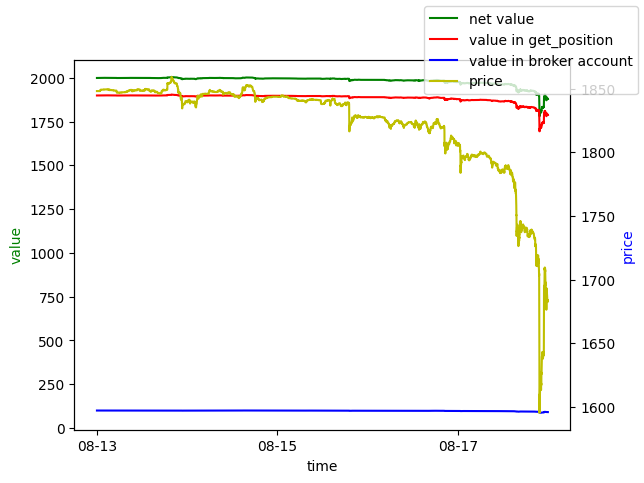

In [9]:
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)